In [1]:
import os
import time
import warnings
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from deepMNN import correct_scanpy
from metrics import compute_entropy, silhouette_coeff_ASW

warnings.filterwarnings("ignore")

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100)
sc.settings.set_figure_params(dpi_save=300)
sc.logging.print_version_and_date()

os.environ["CUDA_VISIBLE_DEVICES"]="3"

Running Scanpy 1.6.0, on 2021-04-28 21:14.


In [30]:
# path = '/media/bgi/zoubin/single_cell/github_code/harmony2019/data/figure3/exprs_full/'

# adata = sc.read_mtx(path +'matrix.mtx').T

# with open(path + 'barcodes.tsv') as file:
#     lines = file.readlines()
#     barcodes = [line.split('"')[3].split('\n')[0] for line in lines[1:]]
# with open(path + 'genes.tsv') as file:
#     lines = file.readlines()
#     genes = [line.split('"')[3].split('\n')[0] for line in lines[1:]]
    
# adata.var_names = genes
# adata.obs_names = barcodes

# info = pd.read_csv(path + 'metadata_full.csv', index_col=0)

# adata.obs['celltype'] = info['cell_type']
# adata.obs['library_id'] = info['library_id']
# adata.obs['sample_id'] = info['sample_id']
# adata.obs['tissue'] = info['tissue']
# adata.obs['nUMI'] = info['nUMI']
# adata.obs['nGene'] = info['nGene']
# adata.obs['percent.mito'] = info['percent.mito']
# adata.obs['percent.ribo'] = info['percent.ribo']

# adata.write_h5ad('data/HCA.h5ad')

... storing 'celltype' as categorical
... storing 'library_id' as categorical
... storing 'sample_id' as categorical
... storing 'tissue' as categorical


In [2]:
adata = sc.read_h5ad('data/HCA.h5ad')
adata.obs['batch'] = adata.obs['tissue']

celltypes = adata.obs.celltype.tolist()
consider_celltypes = ['CLP', 'CMP', 'DC', 'Erythrocytes', 'Fibroblasts', 'GMP', 'HSC', 'Macrophages', 
                      'Megakaryocytes', 'Memory.B.cells', 'MEP',
                      'Mono', 'MPP', 'Myeloid.progenitor', 'naive.B.cells', 'PBMC_cd4mem', 'PBMC_cd4naive', 'PBMC_cd8mem',
                      'PBMC_cd8naive', 'PBMC_nk', 'PBMC_treg', 'Plasma.cells']
celltypes=['DC' if i.startswith('DC') else i for i in celltypes]
celltypes=['Mono' if i.startswith('Mono') else i for i in celltypes]
celltypes=['remove' if i not in consider_celltypes else i for i in celltypes]
adata.obs['celltype'] = celltypes
adata = adata[adata.obs.celltype != 'remove']

sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:,adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:17)


Trying to set attribute `.uns` of view, copying.


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:01:41)


In [3]:
batch_names = adata.obs['tissue'].value_counts().index.values
adatas = [adata[adata.obs['tissue'] == batch_names[i]] for i in range(0, len(batch_names))]

# Before batch correction

In [4]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:06:42)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:14:42)


... storing 'celltype' as categorical


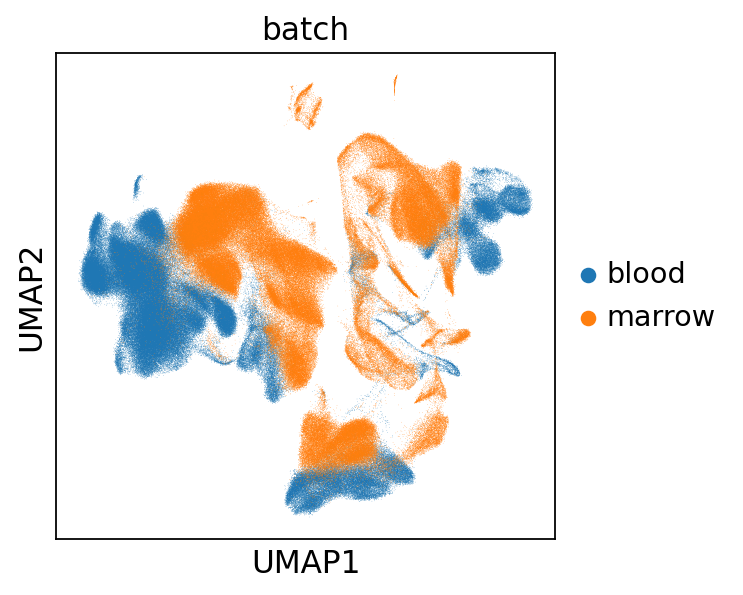

In [5]:
sc.pl.umap(adata,color='batch',save='_figure6_raw_batch.pdf')

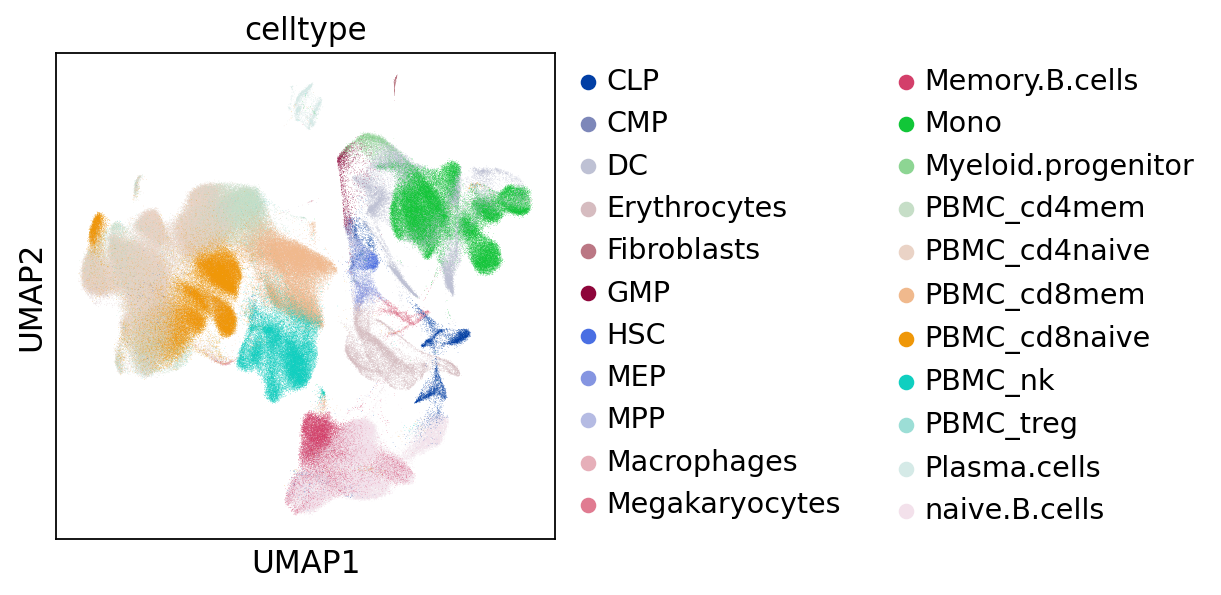

In [6]:
sc.pl.umap(adata,color='celltype',save='_figure6_raw_celltype.pdf')

# Batch correction using deepMNN

In [7]:
time_s = time.time()
corrected = correct_scanpy(adatas)
print('time used:', time.time()-time_s)

adata_result = corrected[0].concatenate(corrected[1:], join='inner', batch_key = 'tissue')
sc.tl.pca(adata_result, svd_solver='arpack')
sc.pp.neighbors(adata_result)
sc.tl.umap(adata_result)

[[0.         0.28031426]
 [0.         0.        ]]
Epoch 0, loss: 171.459, counter: 0
Learning rate = 0.1000000
Epoch 1, loss: 63.029, counter: 0
Learning rate = 0.1000000
Epoch 2, loss: 58.708, counter: 0
Learning rate = 0.1000000
Epoch 3, loss: 56.304, counter: 0
Learning rate = 0.1000000
Epoch 4, loss: 55.920, counter: 0
Learning rate = 0.1000000
Epoch 5, loss: 54.681, counter: 0
Learning rate = 0.1000000
Epoch 6, loss: 53.583, counter: 0
Learning rate = 0.1000000
Epoch 7, loss: 51.800, counter: 0
Learning rate = 0.1000000
Epoch 8, loss: 49.936, counter: 0
Learning rate = 0.1000000
Epoch 9, loss: 47.838, counter: 0
Learning rate = 0.1000000
Epoch 10, loss: 46.805, counter: 0
Learning rate = 0.1000000
Epoch 11, loss: 44.098, counter: 0
Learning rate = 0.1000000
Epoch 12, loss: 43.284, counter: 0
Learning rate = 0.1000000
Epoch 13, loss: 41.452, counter: 0
Learning rate = 0.1000000
Epoch 14, loss: 40.660, counter: 0
Learning rate = 0.1000000
Epoch 15, loss: 39.277, counter: 0
Learning

... storing 'celltype' as categorical
... storing 'library_id' as categorical
... storing 'sample_id' as categorical
... storing 'batch' as categorical


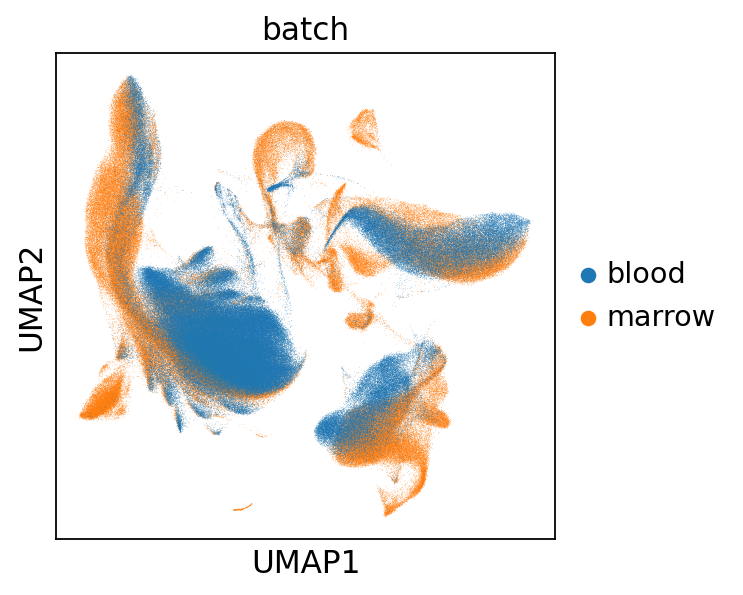

In [8]:
sc.pl.umap(adata_result,color='batch',save='_figure6_deepMNN_batch.pdf')

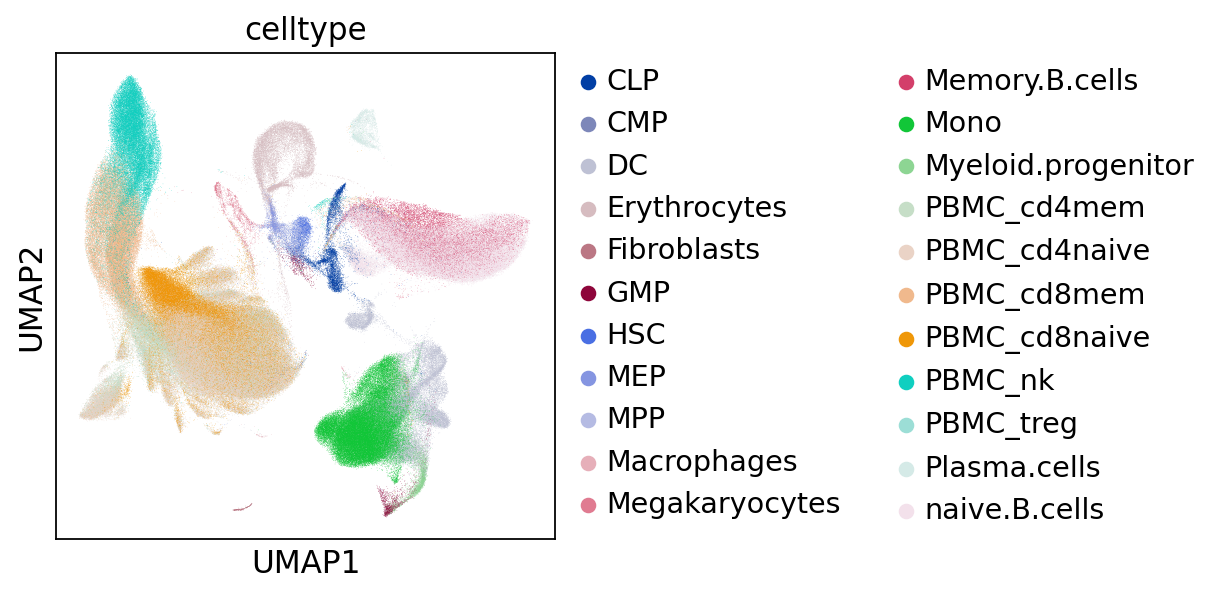

In [9]:
sc.pl.umap(adata_result,color='celltype',save='_figure6_deepMNN_celltype.pdf')

# Batch correction using Scanorama

In [10]:
import scanorama

adata = sc.read_h5ad('data/HCA.h5ad')
adata.obs['batch'] = adata.obs['tissue']

celltypes = adata.obs.celltype.tolist()
consider_celltypes = ['CLP', 'DC', 'Erythrocytes', 'GMP', 'HSC', 'Megakaryocytes', 'Memory.B.cells',
                      'Mono', 'MPP', 'naive.B.cells', 'PBMC_cd4mem', 'PBMC_cd4naive', 'PBMC_cd8mem',
                      'PBMC_cd8naive', 'PBMC_nk', 'PBMC_treg', 'Plasma.cells']
celltypes=['DC' if i.startswith('DC') else i for i in celltypes]
celltypes=['Mono' if i.startswith('Mono') else i for i in celltypes]
celltypes=['remove' if i not in consider_celltypes else i for i in celltypes]
adata.obs['celltype'] = celltypes
adata = adata[adata.obs.celltype != 'remove']

sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='seurat')
adata = adata[:,adata.var['highly_variable']]

adatas = [adata[adata.obs['tissue'] == i,:].copy() for i in ['blood', 'marrow']]

time_s = time.time()
corrected = scanorama.correct_scanpy(adatas)
print('time used:', time.time()-time_s)

corrected_dataset = corrected[0].concatenate(corrected[1:], join='inner', batch_key = 'tissue')
sc.tl.pca(corrected_dataset, svd_solver='arpack')
sc.pp.neighbors(corrected_dataset)
sc.tl.umap(corrected_dataset)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:14)


Trying to set attribute `.uns` of view, copying.


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Found 2000 genes among all datasets
[[0.         0.29360654]
 [0.         0.        ]]
Processing datasets (0, 1)
time used: 4662.754366397858
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:03:14)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:07:21)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:14:29)


... storing 'celltype' as categorical
... storing 'library_id' as categorical
... storing 'sample_id' as categorical
... storing 'batch' as categorical


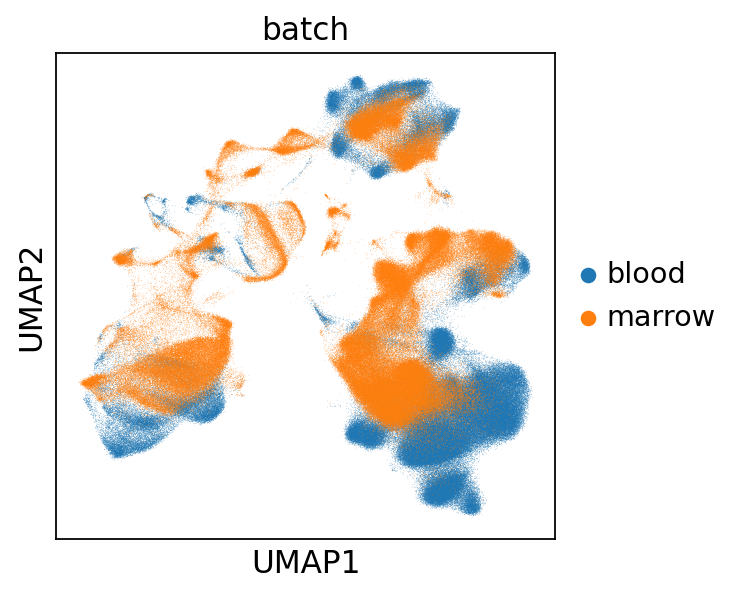

In [11]:
sc.pl.umap(corrected_dataset,color='batch',save='_figure6_Scanorama_batch.pdf')

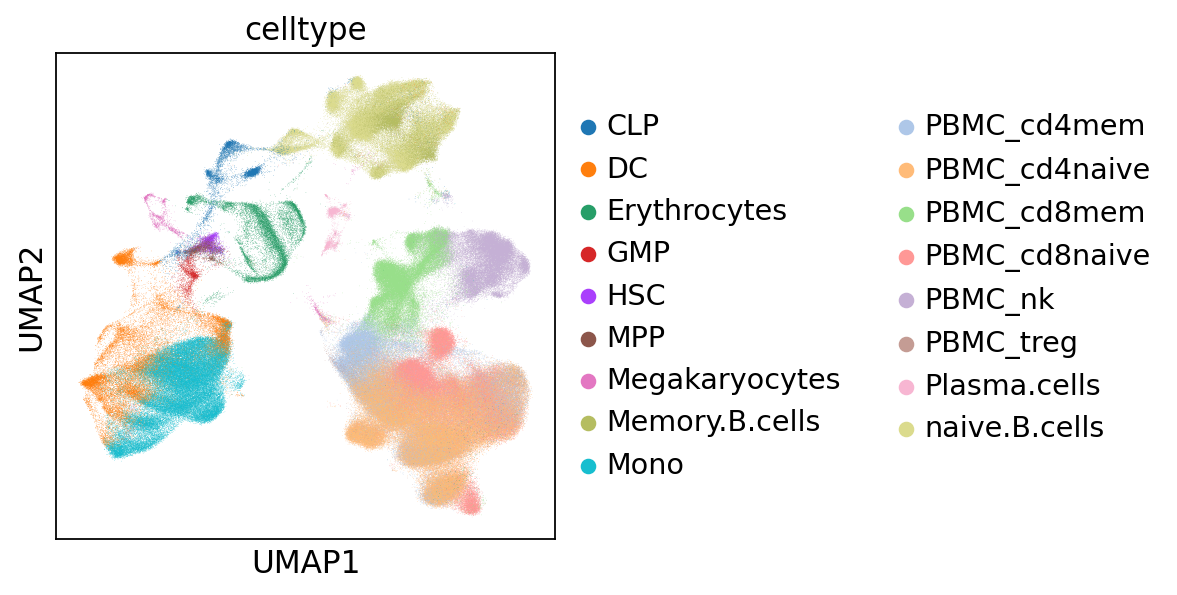

In [12]:
sc.pl.umap(corrected_dataset,color='celltype',save='_figure6_Scanorama_celltype.pdf')